In [ ]:
!sudo pip install networkx==1.10

In [1]:
from IPython.display import HTML
html = open('accessing-dependencies.html').read()
HTML(html)

### Examples of Traversing the Tree

##### Merge compound verb phrases

I, do, not, like, pizza, . $\rightarrow$ I, do not like, pizza, .


In [1]:
import spacy
from spacy.symbols import aux, auxpass, neg, VERB

is_auxiliary_to_verb = lambda token: token.dep in (aux, auxpass, neg)
is_non_auxiliary_verb = lambda token: token.pos == VERB and not is_auxiliary_to_verb(token)

def merge_compound_verb_phrases(doc):
    #find all non auxiliary verbs in document
    verbs = filter(is_non_auxiliary_verb, doc)
    
    #get surrounding spans of verbs
    verb_spans = map(get_span_of_surrounding_verbs, verbs)
    
    #merge each span
    for span in verb_spans:
        span.merge()


def get_span_of_surrounding_verbs(verb):
    left_idx, right_idx = 0,0
    
    #grab left dependencies (closest first) that are auxiliary verbs
    for left in list(verb.lefts)[::-1]:
        if is_auxiliary_to_verb(left):
            left_idx -= 1 #expand span to include word
        else:
            break
       
    #grab right dependencies (closest first) that are auxiliary verbs
    for right in verb.rights:
        if is_auxiliary_to_verb(right):
            right_idx += 1 #expand span to include word
        else:
            break            
        
    #return slice of contiguous, related verbs
    span = verb.doc[verb.i + left_idx: verb.i + 1 + right_idx]
    return span



In [2]:
def new_pipeline(nlp):
    return (
        nlp.tagger,
        nlp.parser,
        nlp.matcher,
        nlp.entity,
        merge_compound_verb_phrases
        )

nlp_with_verb_merging = spacy.load('en', create_pipeline = new_pipeline)

In [22]:
doc = nlp_with_verb_merging(u'the man does not like the pizza')
print list(doc)

[the, man, does not like, the, pizza]


In [21]:
from IPython.display import IFrame
IFrame(src='https://demos.explosion.ai/displacy/?text=The%20man%20ate.&model=en&cpu=1&cph=1', width = 800, height = 400)

In [56]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 7)

class DependencyGraph(object):
    """
    Create networkx object holding parse. Plot the graph
    """
    
    
    def __init__(self, spacy_sentence):
        """
        Parameters
        ----------
        spacy_sentence (spacy.span.span.Span):
            Span of a sentence or phrase in spacy
        """
        self.sentence = spacy_sentence
        self.graph = self.sentToGraph()
        
        
    
    def sentToGraph(self):
        
        def recurseOnGraph(token, graph):
            for child in token.children:
                graph.add_node(child.i, {'word':child.orth_,'tag':child.tag_})
                graph.add_edge(token.i, child.i, {'dep':child.dep_})
                recurseOnGraph(child, graph)
            return graph
        
        graph = nx.DiGraph()
        root = self.sentence.root
        graph.add_node(root.i, {'word':root.orth_,'tag':root.tag_})        
        return recurseOnGraph(root, graph)   
    
    def plot_graph(self, with_labels=True,arrows=False, font_size=18, node_size=2000, **kwargs):
        f, ax = plt.subplots(1)
        edge_labels = edge_labels=dict([((u,v,),d['dep']) for u,v,d in self.graph.edges(data=True)])
        node_labels = {i:g.graph.node[i]['word'] for i in g.graph.node.keys()}

        pos = nx.graphviz_layout(self.graph,prog='dot')
        
        nx.draw(self.graph,
                pos,
                labels = node_labels,
                with_labels = with_labels,
                arrows=arrows, 
                font_size=font_size, 
                node_size=node_size, 
                ax=ax, 
                **kwargs
        )
        
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels,ax=ax, font_size=14)
        
        ax.set_title(self.sentence.text_with_ws, size = 22)
        return ax

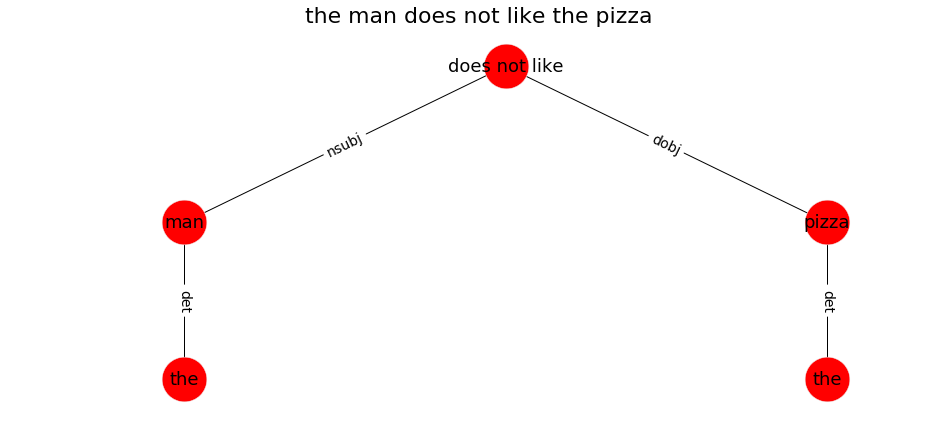

In [57]:
g = DependencyGraph(list(doc.sents)[0])
g.plot_graph()
plt.show()